In [77]:
import pandas as pd
import json
import os
import time
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


In [2]:
####   Function to load data https://www.kaggle.com/ldmtwo/simple-data-loader-and-parser  ####
####  The original function was modified to work properly according to data   ######
def Load(file, max_rows=None, DROP=[], with_prefix=True):
    from pandas.io.json import json_normalize
    t0 = time.time()
    columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(file, 
                     converters={column: json.loads for column in columns}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=max_rows)
    print(df.shape)
    lst = [df]
    for c in columns:
        tmp = json_normalize(list(df[c].values))
        if with_prefix: tmp.columns = [f"{c}.{subcolumn}" for subcolumn in tmp.columns]
        lst.append(tmp)     
        print('%20s  +%s'%(c,tmp.shape))
    df = pd.concat(lst, axis=1)
    print('->',df.shape)
    DROP = [c for c in columns+DROP if c in df.columns]
    df.drop(DROP, axis=1, inplace=True)
    print('DROP %s ->'%len(DROP),df.shape)
    print('Loaded %s in %s sec'%(file,time.time()-t0))
    return df

#feel free to check for your self (set it to [])
useless=['device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', \
         'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', \
         'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', \
         'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude',\
         'geoNetwork.longitude', 'geoNetwork.networkLocation', 'socialEngagementType', 'totals.visits', \
         'trafficSource.adwordsClickInfo.criteriaParameters','trafficSource.campaignCode']



#### Run Below two cells only once

In [3]:
train_df = Load('train.csv',DROP=useless)
train_df.to_csv('final_train.csv')

(903653, 12)
              device  +(903653, 16)
          geoNetwork  +(903653, 11)
              totals  +(903653, 6)
       trafficSource  +(903653, 14)
-> (903653, 59)
DROP 24 -> (903653, 35)
Loaded train.csv in 122.41823387145996 sec


In [17]:
test_df = Load('test.csv',DROP=useless)
test_df.to_csv('final_test.csv')

(804684, 12)
              device  +(804684, 16)
          geoNetwork  +(804684, 11)
              totals  +(804684, 5)
       trafficSource  +(804684, 13)
-> (804684, 57)
DROP 23 -> (804684, 34)
Loaded test.csv in 122.5051519870758 sec


In [90]:
train_df = pd.read_csv('final_train.csv',encoding='ISO-8859-1')
test_df = pd.read_csv('final_test.csv',encoding='ISO-8859-1')

E:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'],
      dtype='object')

In [34]:
train_df['geoNetwork.region'].describe()

count                            903653
unique                              376
top       not available in demo dataset
freq                             508229
Name: geoNetwork.region, dtype: object

In [6]:
train_df['totals.transactionRevenue'].fillna(value=0,inplace=True)

In [7]:
train_df['totals.transactionRevenue']=train_df['totals.transactionRevenue'].astype('int64')

In [79]:
train_df['totals.transactionRevenue'].describe([.25,.50,.75,.90])

count    9.036530e+05
mean     1.704273e+06
std      5.277866e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
90%      0.000000e+00
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

In [10]:
train_df['totals.transactionRevenue'].head()

0    0
1    0
2    0
3    0
4    0
Name: totals.transactionRevenue, dtype: object

In [8]:
train_df.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google


## EDA

#### Channel through which users are comming 

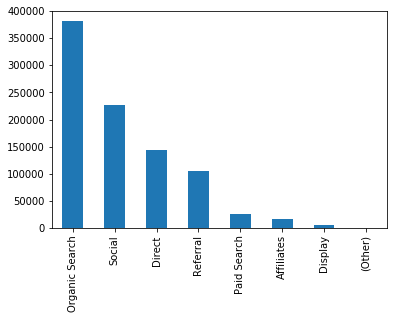

In [16]:
train_df['channelGrouping'].value_counts().plot(kind='bar')
plt.show()

#### Traffic medium

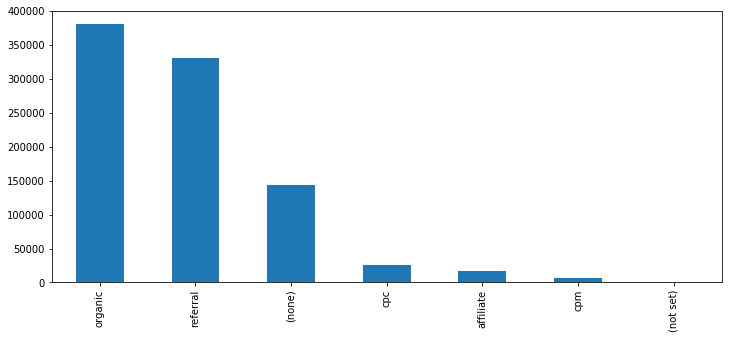

In [84]:
train_df['trafficSource.medium'].value_counts().plot(kind='bar',figsize=(12,5))
plt.show()


#### Browser through which users are comming

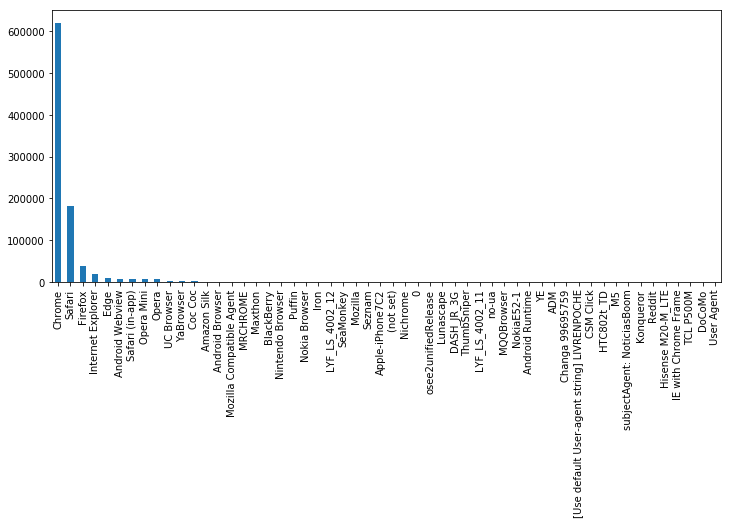

In [26]:
train_df['device.browser'].value_counts().plot(kind='bar',figsize=(12,5))
plt.show()

#### revenue users are making 
As most of the users gone without buying stuff you can see most values are zero

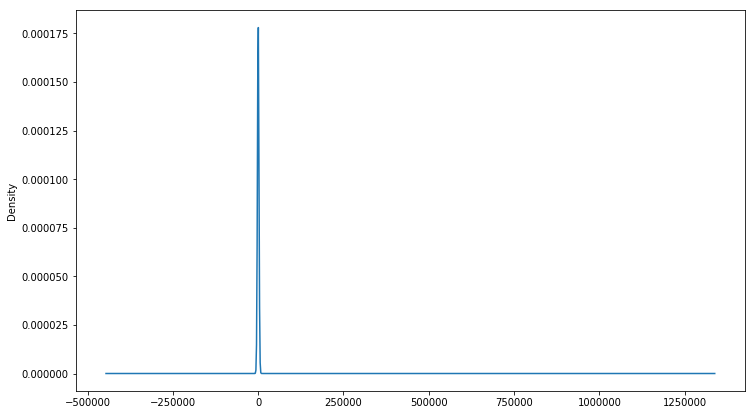

In [81]:
train_df['totals.transactionRevenue'].value_counts().plot(kind='kde',figsize=(12,7))
plt.show()

#### Most used devices for accessing gstore

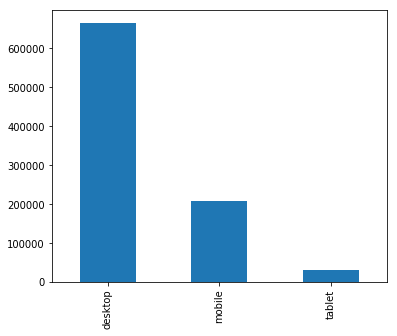

In [39]:
train_df['device.deviceCategory'].value_counts().plot(kind='bar',figsize=(6,5))
plt.show()


#### Continents accessing gstore

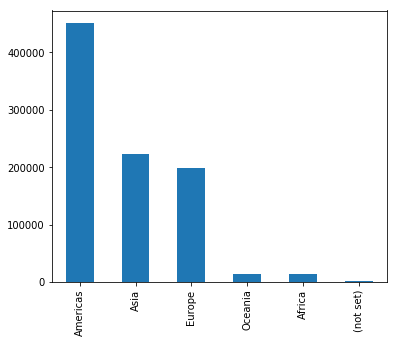

In [43]:
train_df['geoNetwork.continent'].value_counts().plot(kind='bar',figsize=(6,5))
plt.show()



### Subcontinents

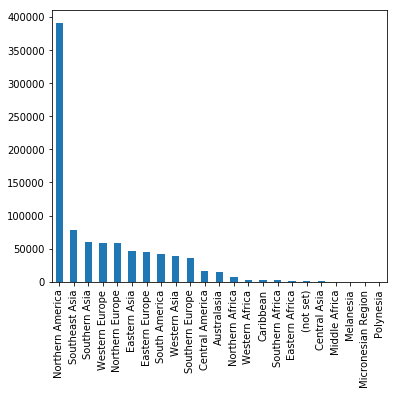

In [45]:
train_df['geoNetwork.subContinent'].value_counts().plot(kind='bar',figsize=(6,5))
plt.show()


In [52]:
train_df.columns

Index(['Unnamed: 0', 'channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'visitId', 'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'],
      dtype='object')

In [92]:
test_df.columns

Index(['Unnamed: 0', 'channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'visitId', 'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'],
      dtype='object')

## Predicting user transactional revenue

In [91]:
numeric_cols = ['totals.hits','totals.pageviews','visitNumber','totals.newVisits','totals.bounces','totals.transactionRevenue']
#object cols
rest_cols = list(train_df.select_dtypes(include=['object', 'bool']).columns)

train_df[numeric_cols] = train_df[numeric_cols].fillna(0)
for col in numeric_cols:
    train_df[col] = train_df[col].astype('float')
                        
# transfer object columns as category cols
for col in rest_cols:
    train_df[col] =  train_df[col].astype('category').cat.codes

In [88]:
numeric_cols_test = ['totals.hits','totals.pageviews','visitNumber','totals.newVisits','totals.bounces']
test_df[numeric_cols_test] = test_df[numeric_cols_test].fillna(0)
for col in numeric_cols_test:
    test_df[col] = test_df[col].astype('float')
                        
# transfer object columns as category cols
for col in rest_cols:
    test_df[col] =  test_df[col].astype('category').cat.codes

In [101]:
y = pd.DataFrame(columns=['totals.transactionRevenue'])
y[] = train_df['totals.transactionRevenue']
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: totals.transactionRevenue, dtype: float64

In [102]:
# split train and target variables
y = pd.DataFrame(columns=['totals.transactionRevenue'])
y['totals.transactionRevenue'] = train_df['totals.transactionRevenue']
y_train = y['totals.transactionRevenue'][0:722922]
y_cv = y['totals.transactionRevenue'][722922:]
train_df = train_df.drop('totals.transactionRevenue', axis=1)
train = train_df[0:722922]
cv = train_df[722922:]

In [110]:
params={'learning_rate' :[0.001],
'num_leaves' :[150],
'num_trees' : [500],
'num_threads':[16],
'min_data_in_leaf':[0],
'min_sum_hessian_in_leaf':[100]}

gbm = lgb.LGBMRegressor()
#gbm.fit(train_df, target_df)
model = GridSearchCV(gbm, params, scoring = 'neg_mean_squared_error', cv=10)
model.fit(train,y_train)

E:\anaconda\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
E:\anaconda\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
E:\anaconda\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
E:\anaconda\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
E:\anaconda\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.w

GridSearchCV(cv=10, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.001], 'num_leaves': [150], 'num_trees': [500], 'num_threads': [16], 'min_data_in_leaf': [0], 'min_sum_hessian_in_leaf': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [112]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(cv)
print(mean_squared_error(y_cv,y_pred))

2530382373960394.5
